# ∆QT Database Example Use

Sample notebook for querying ∆QT Database ([download this notebook](/index/static/QTDb_example_use.ipynb))

Can also incorporate [Twosides](http://tatonettilab.org/resources/tatonetti-stm.html) for gathering additional evidence for drug-side effect relationships 

**Input:**  [Drug(s) to evaluate from list of drugs in database](#input)

**Step 1:** [Define function for extracting ∆QTs from API](#step1)

**Step 2:** [API call to obtain ∆QTs for each individual drug and combination](#step2)

**Step 3:** [Bin ∆QTs for visualizing in histogram](#step3)

**Step 4:** [Visualize ∆QTs](#step4)


In [1]:
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from urllib2 import Request, urlopen, URLError
import json

import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
#import seaborn as sns

### Demo

<a id='input'></a>
**Input:** Drug(s) to evaluate from list of drugs in database

In [3]:
# Obtain list of possible drugs
concept2name = dict()
name2concept = dict()

request = Request('http://deltaqt.org/index/js/drugs-brandnames-v4.js')
response = urlopen(request).read()

for line in response.split('\n'):
    if line.startswith('//') == False and line.startswith('var') == False and line not in ['','];']:
        if line.split("'")[1].startswith('('):
            continue
        concept_id = int(line.split("'")[1])
        drugname = line.split("'")[-2].split('(')[0].strip()
        #print concept_id, drugname
        concept2name[concept_id] = drugname
        name2concept[drugname] = concept_id

print '\n',len(concept2name), "drugs found"


251 drugs found


In [4]:
# Test for amiodarone alone
print name2concept['Amiodarone']
drugs = [1309944]
drugs_api_str = ",".join([str(d) for d in drugs])
drugs_api_str

1309944


'1309944'

In [5]:
# Test for ceftriaxone and lansoprazole
print name2concept['Ceftriaxone'], name2concept['Lansoprazole']
drugs = [1777806, 929887]
drugs_api_str = ",".join([str(d) for d in drugs])
drugs_api_str

1777806 929887


'1777806,929887'

<a id='step1'></a>
**Step 1:** Define function for extracting ∆QTs from API

In [6]:
def pull_deltas(drugs_api_str, cached=False):
    if ',' in drugs_api_str:
        cached = True
    
    delta_qts = []
    cached_qts = []
    request = Request('http://deltaqt.org/api/v1/query?drugs=%s' %drugs_api_str)
    
    try:
        response = urlopen(request).read()
        decoded = json.loads(response)
        #print len(decoded)

        for p in decoded['delta_qts']:
            delta_qts.append( p['delta'] )
            
        if cached == True:
            for p in decoded['cache_'+drugs_api_str.split(',')[1]]:
                cached_qts.append( p['delta'] )
            
    except URLError, e:
        print '%s not found in database' %drugs_api_str, e
    
    if cached == True:
        return delta_qts, cached_qts
    else:
        return delta_qts

<a id='step2'></a>
**Step 2:** API call to obtain ∆QTs for each individual drug and combination

In [7]:
print drugs
drugs_api_str = ",".join([str(d) for d in drugs])

delta_qts = []
individ_drug_qts = defaultdict(list)

if len(drugs) == 1:
    delta_qts = pull_deltas(drugs_api_str)
elif len(drugs) > 1:
    # API returns deltas for patients taking all N drugs, and for the Nth drug alone
    # Need to run API for 1 – (N-1)th drugs
    for d in drugs[0:-1]:
        individ_drug_qts[d] = pull_deltas(str(d))
    
    delta_qts, individ_drug_qts[drugs[-1]] = pull_deltas(drugs_api_str)

[1777806, 929887]


<a id='step3'></a>
**Step 3:** Bin ∆QTs for visualizing in histogram

In [8]:
thresholds = [-110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

bins = dict()

delta_qts_arr = np.array(delta_qts)
weights = np.ones_like(delta_qts_arr)/float(len(delta_qts_arr))*100.0
hist, bin_edges = np.histogram(delta_qts_arr, weights=weights, bins=thresholds)
bins['all'] = hist

if len(drugs) > 1:
    for d in individ_drug_qts:
        individ_drug_qts_arr = np.array(individ_drug_qts[d])
        weights = np.ones_like(individ_drug_qts_arr)/float(len(individ_drug_qts_arr))*100.0
        hist, bin_edges = np.histogram(individ_drug_qts_arr, weights=weights, bins=thresholds)
        bins[d] = hist
print len(bins), "bins"

3 bins


<a id='step4'></a>
**Step 4:** Visualize ∆QTs

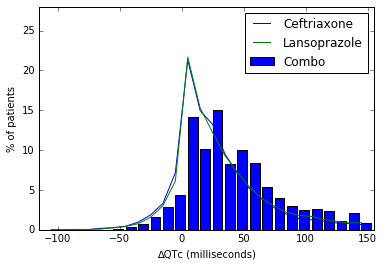

In [9]:
xpos = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
if len(drugs) == 1:
    plt.bar(xpos, bins['all'], width=8, label=concept2name[drugs[0]])

elif len(drugs) > 1:
    plt.bar(xpos, bins['all'], width=8, label='Combo')
    for d in drugs:
        plt.plot(xpos, bins[d], label=concept2name[d])

plt.xlim(-115,155)
plt.ylim(0,28)
plt.xlabel(u'∆QTc (milliseconds)')
plt.ylabel('% of patients')
plt.legend()